In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import datetime
import os
import xarray as xr

from utils import normalize

from mod_moving_mnist import ModMovingMNIST
from mpnnlstm import NextFramePredictor

/Users/zach/opt/miniconda3/envs/mpnnlstm/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
# fetch = False
# if fetch:
#     import sys 
#     sys.path.append('/Users/zach/Library/CloudStorage/OneDrive-UniversityofWaterloo/Documents/MASc/test')

#     import datetime 
#     from glorys import get_glorys

#     ds = get_glorys()
#     ds = ds.sel(latitude=slice(51, 70), longitude=slice(-95, -65))[['siconc']]
#     ds = ds.sel(time=slice(datetime.datetime(2013, 1, 1), datetime.datetime(2018, 1, 1)))
# else:
#     ds = xr.open_dataset('data/glorys.nc')

ds = xr.open_zarr('data/era5_hb_daily.zarr')
mask = np.isnan(ds.siconc.isel(time=0)).values

In [5]:
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Number of frames to read as input
input_timesteps = 3
output_timesteps= 1

def xarray_to_x_y(ds, start_date, end_date, input_timesteps, output_timesteps, coarsen=0):
    ds = ds.sel(time=slice(start_date, end_date))
    ds = (ds - ds.min()) / (ds.max() - ds.min())

    if coarsen != 0:
        ds = ds.coarsen(latitude=coarsen, longitude=coarsen, boundary='trim').mean()
    num_samples = ds.time.size-output_timesteps-input_timesteps
    i = 0
    x = np.ndarray((num_samples, input_timesteps, ds.latitude.size, ds.longitude.size, len(ds.data_vars)))
    y = np.ndarray((num_samples, output_timesteps, ds.latitude.size, ds.longitude.size, len(ds.data_vars)))
    while i + output_timesteps + input_timesteps < ds.time.size:
        x[i] = np.moveaxis(np.nan_to_num(ds.isel(time=slice(i, i+input_timesteps)).to_array().to_numpy()), 0, -1)
        y[i] = np.moveaxis(np.nan_to_num(ds.isel(time=slice(i+input_timesteps, i+input_timesteps+output_timesteps)).to_array().to_numpy()), 0, -1)
        i += 1

    return x, y

coarsen=0
x_vars = ['siconc', 't2m', 'v10', 'u10', 'sshf']
# x_vars = list(ds.data_vars)

# x, y = xarray_to_x_y(ds[x_vars], datetime.datetime(1995, 6, 1), datetime.datetime(1995, 9, 1), input_timesteps, output_timesteps, coarsen=coarsen)
x, y = [], []
for year in range(1995, 2006):
    x_year, y_year = xarray_to_x_y(ds[x_vars], datetime.datetime(year, 6, 1), datetime.datetime(year, 9, 1), input_timesteps, output_timesteps, coarsen=coarsen)
    x.append(x_year)
    y.append(y_year)
x = np.concatenate(x, 0)
y = np.concatenate(x, 0)

x_test, y_test = xarray_to_x_y(ds[x_vars], datetime.datetime(2004, 7, 1), datetime.datetime(2004, 8, 1), input_timesteps, output_timesteps, coarsen=coarsen)
x_val, y_val = xarray_to_x_y(ds[x_vars], datetime.datetime(2005, 7, 1), datetime.datetime(2005, 8, 1), input_timesteps, output_timesteps, coarsen=coarsen)

In [6]:
model_kwargs = dict(
    hidden_size=64,
    dropout=0.1,
    multi_step_loss=output_timesteps,
    input_timesteps=input_timesteps
    )

model = NextFramePredictor(experiment_name='test', decompose=True, input_features=len(x_vars), integrated_space_time=False, **model_kwargs)
model.get_n_params()

80517

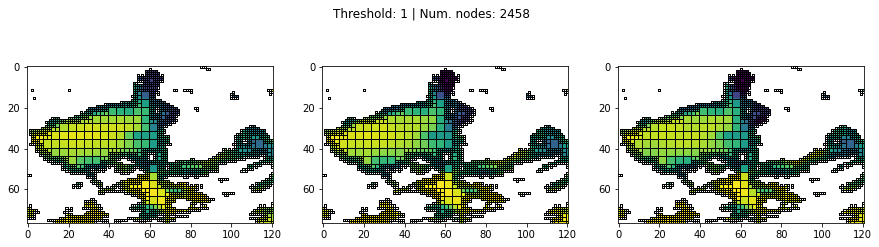

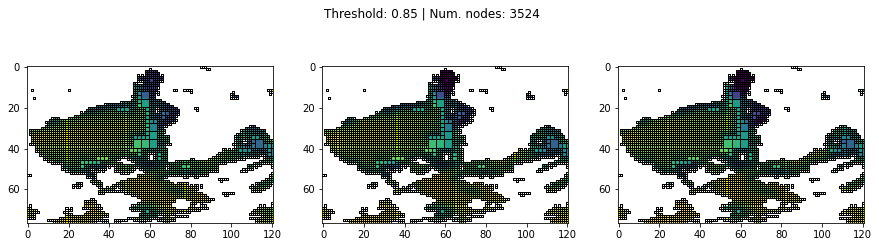

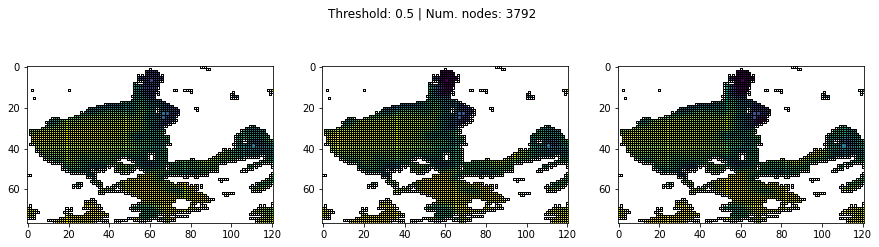

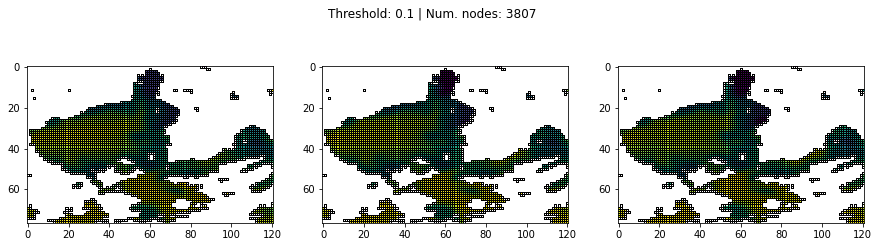

In [8]:
frame_index = 1

fig, axs = model.test_threshold(x_val[:10], thresh=1, frame_index=frame_index, mask=mask)
plt.show()

fig, axs = model.test_threshold(x_val[:10], thresh=0.85, frame_index=frame_index, mask=mask)
plt.show()

fig, axs = model.test_threshold(x_val[:10], thresh=0.5, frame_index=frame_index, mask=mask)
plt.show()

fig, axs = model.test_threshold(x_val[:10], thresh=0.1, frame_index=frame_index, mask=mask)
plt.show()

import cProfile
cProfile.run('model.train(x[:10], y[:10], x_test[:10], y_test[:10], lr=lr, n_epochs=1, mask=None)', sort=1)

In [30]:
model = NextFramePredictor(experiment_name='test', decompose=True, input_features=len(x_vars), integrated_space_time=False, **model_kwargs)

model.set_thresh(0.15)  # Set the threshold based on the plots above
# model.set_thresh(-np.inf)  # Set the threshold based on the plots above

lr = 0.1

model.model.train()
model.train(x, y, x_test, y_test, lr=lr, n_epochs=50, mask=mask)  # Train for 20 epochs

# model.model.eval()
# model.score(x_val, y_val[:, :1])  # Check the MSE on the validation set

Epoch 0 train loss: 0.6251, test loss: 0.6515, lr: 0.1000, time_per_epoch: 25.4


Epoch 1 train loss: 0.5948, test loss: 0.6266, lr: 0.1000, time_per_epoch: 25.6


Epoch 2 train loss: 0.5872, test loss: 0.6259, lr: 0.1000, time_per_epoch: 25.9


Epoch 3 train loss: 0.5868, test loss: 0.6249, lr: 0.1000, time_per_epoch: 25.9


Epoch 4 train loss: 0.5865, test loss: 0.6238, lr: 0.1000, time_per_epoch: 26.0


Epoch 5 train loss: 0.5861, test loss: 0.6233, lr: 0.1000, time_per_epoch: 26.0


Epoch 6 train loss: 0.5859, test loss: 0.6233, lr: 0.1000, time_per_epoch: 26.0


Epoch 7 train loss: 0.5858, test loss: 0.6231, lr: 0.1000, time_per_epoch: 26.1


Epoch 8 train loss: 0.5857, test loss: 0.6229, lr: 0.1000, time_per_epoch: 26.1


Epoch 9 train loss: 0.5856, test loss: 0.6229, lr: 0.0950, time_per_epoch: 26.1


Epoch 10 train loss: 0.5855, test loss: 0.6228, lr: 0.0950, time_per_epoch: 26.1


Epoch 11 train loss: 0.5855, test loss: 0.6226, lr: 0.0950, time_per_epoch: 26.1


Epoch 12 train loss: 0.5855, test loss: 0.6226, lr: 0.0950, time_per_epoch: 26.0


Epoch 13 train loss: 0.5854, test loss: 0.6226, lr: 0.0950, time_per_epoch: 26.1


Epoch 14 train loss: 0.5853, test loss: 0.6226, lr: 0.0950, time_per_epoch: 26.3


Epoch 15 train loss: 0.5853, test loss: 0.6226, lr: 0.0950, time_per_epoch: 26.5


Epoch 16 train loss: 0.5853, test loss: 0.6228, lr: 0.0950, time_per_epoch: 26.5


Epoch 17 train loss: 0.5852, test loss: 0.6226, lr: 0.0950, time_per_epoch: 26.5


KeyboardInterrupt: 

In [31]:
model.loss.iloc[1:].plot()
# model.loss.to_csv('ice_results/loss.csv')

AttributeError: 'NextFramePredictor' object has no attribute 'loss'

In [34]:
ar_steps = 30

launch_step = 0

# Get predictions on the validation set
model.model.eval()
y_hat = model.predict(x_val[[launch_step]], ar_steps)

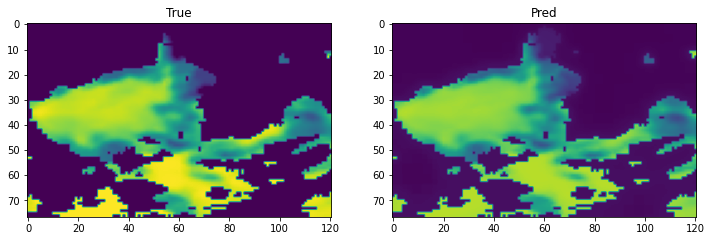

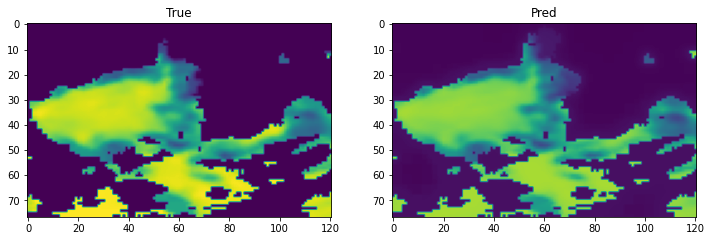

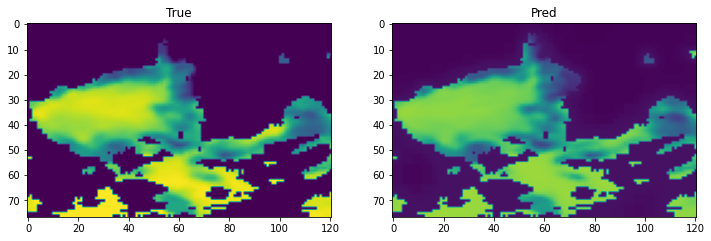

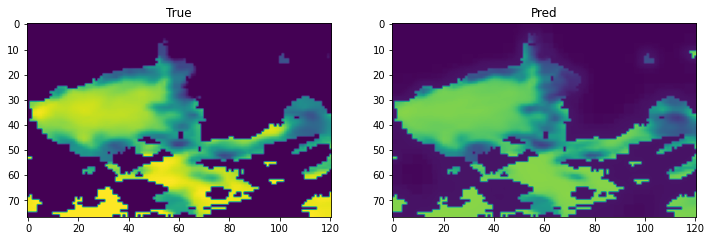

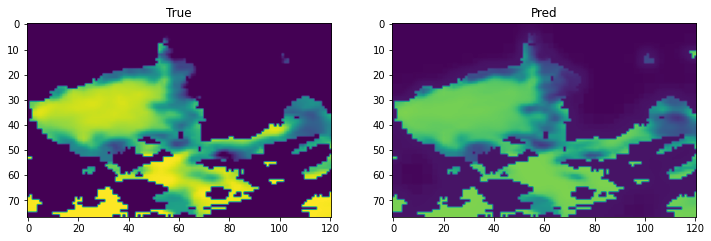

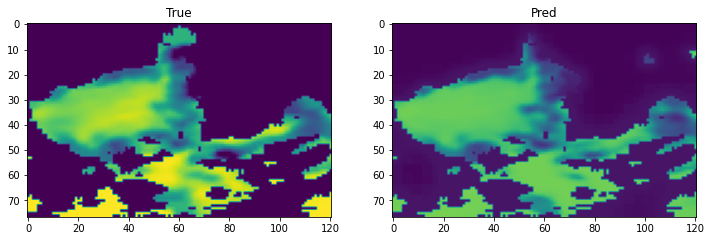

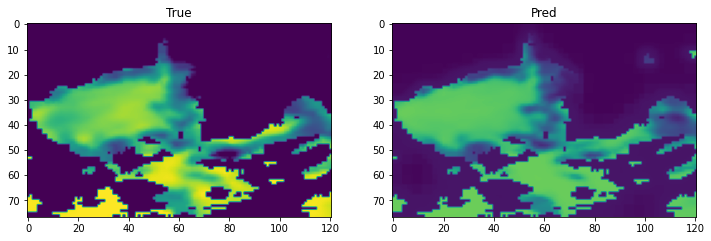

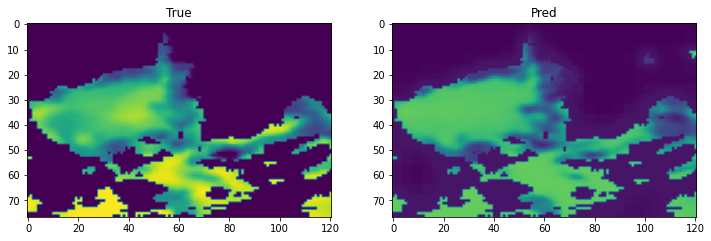

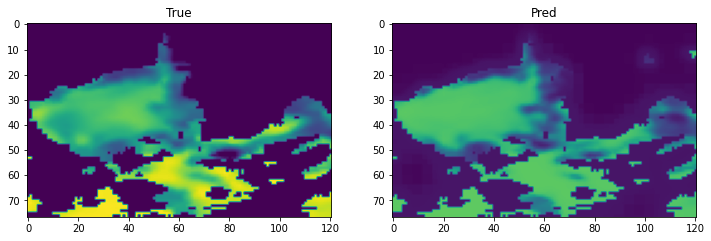

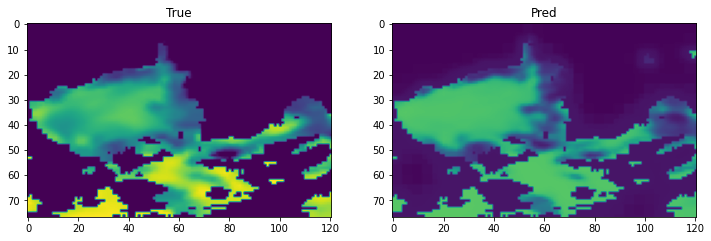

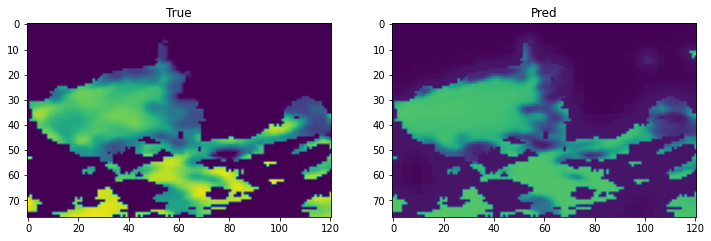

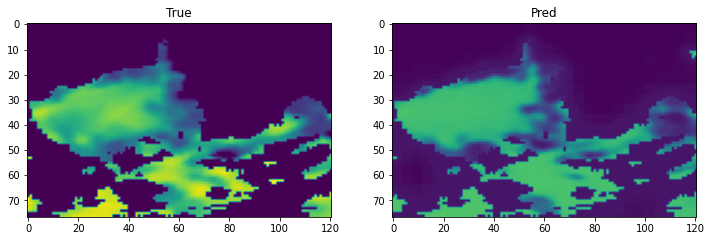

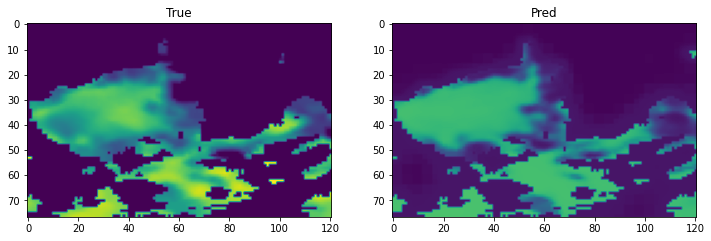

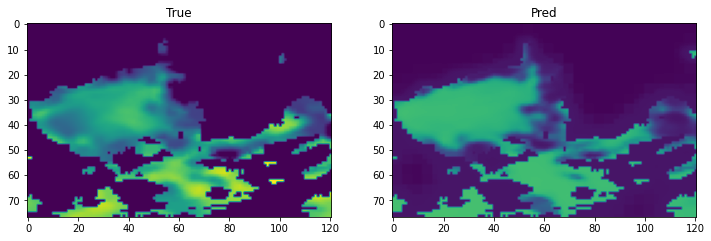

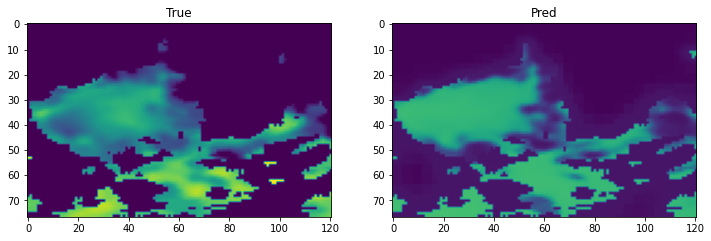

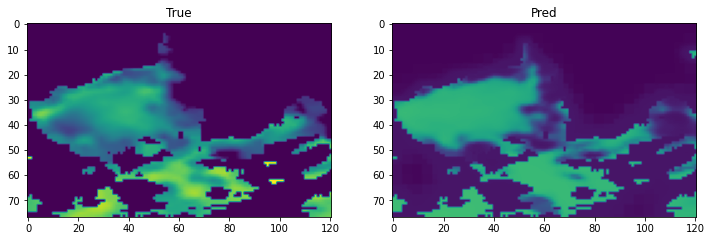

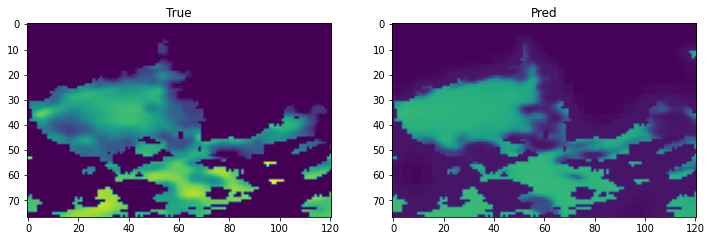

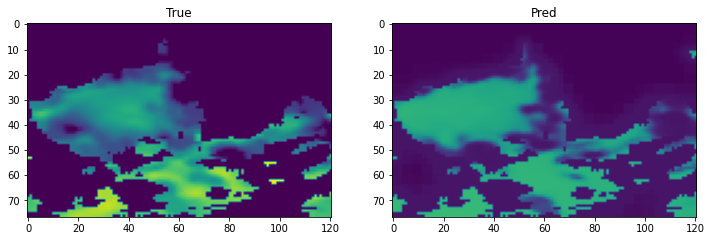

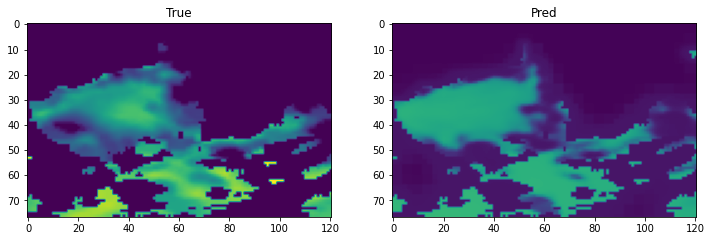

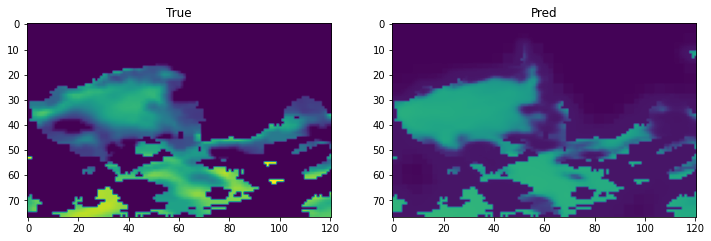

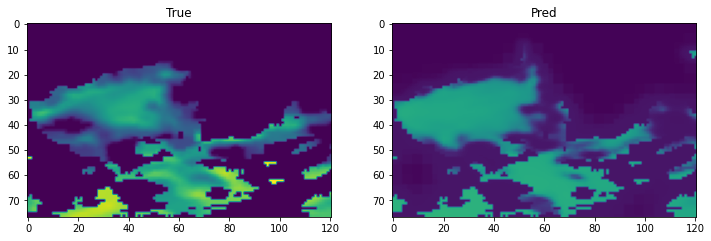

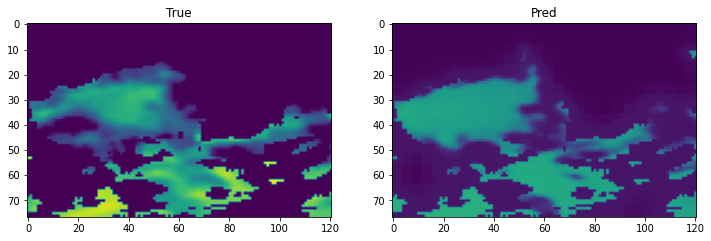

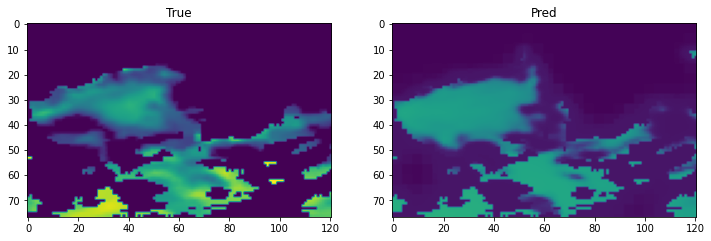

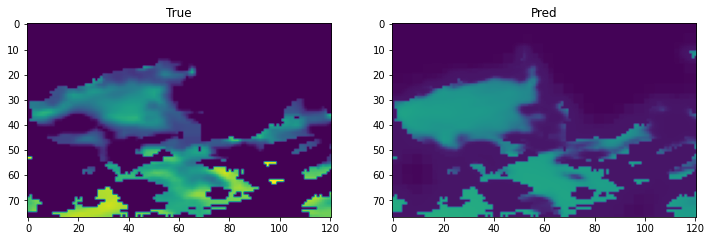

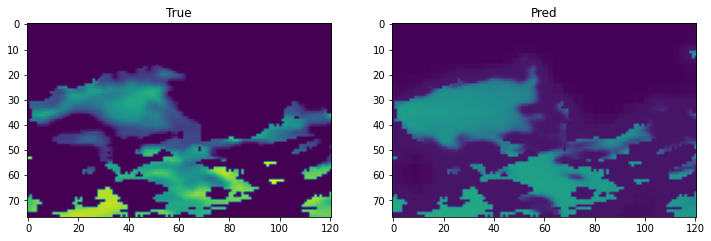

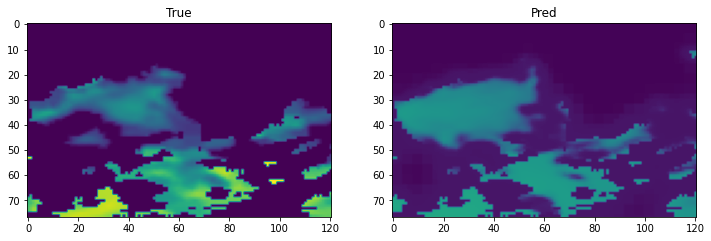

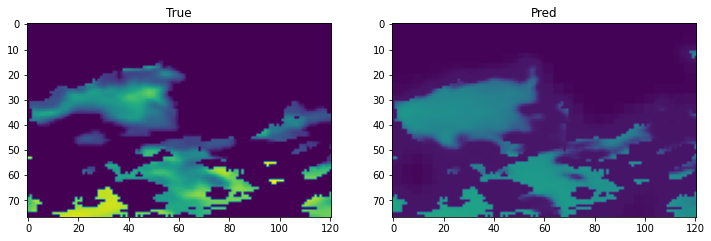

IndexError: index 27 is out of bounds for axis 0 with size 27

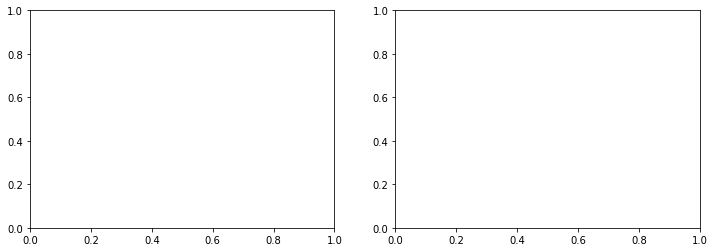

In [35]:
mask = np.zeros((77, 121)).astype(bool)
for i in range(ar_steps):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    y_val_step = y_val[launch_step + i].squeeze(0)[..., 0]
    y_hat_step = y_hat.squeeze(0)[i][..., 0]
    axs[0].imshow(np.where(~mask, y_val_step, np.nan), vmin=0, vmax=1)
    axs[1].imshow(np.where(~mask, y_hat_step, np.nan), vmin=0, vmax=1)
    axs[0].set_title('True')
    axs[1].set_title('Pred')
    plt.show()
    # plt.savefig(f'ice_results/example_{i}.png')
    # plt.close()

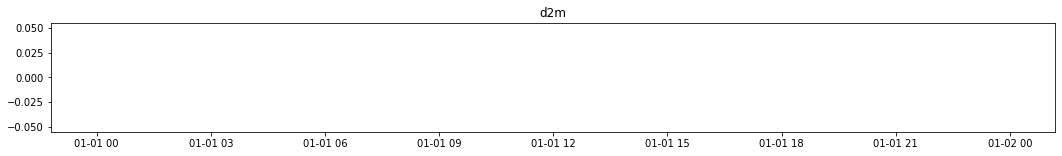

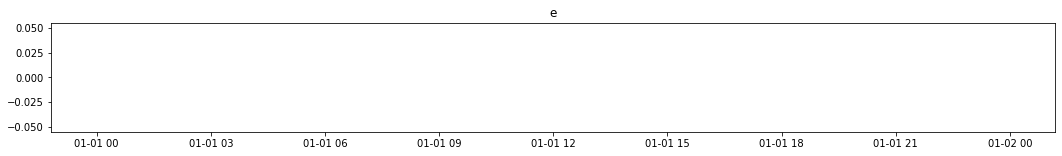

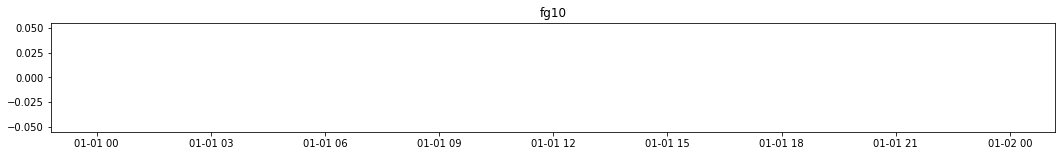

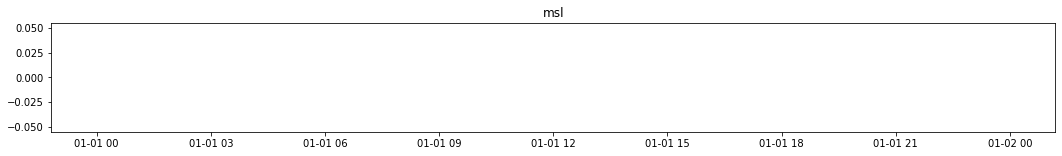

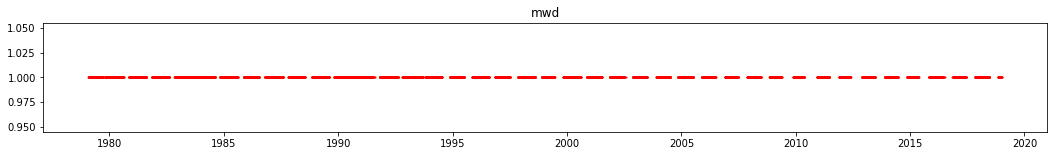

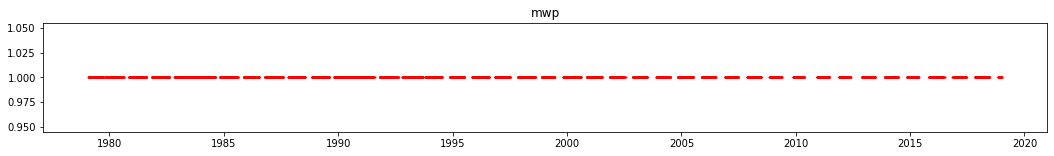

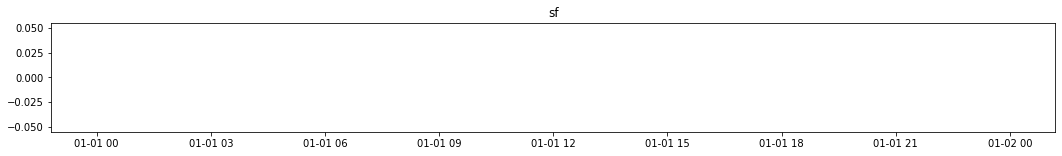

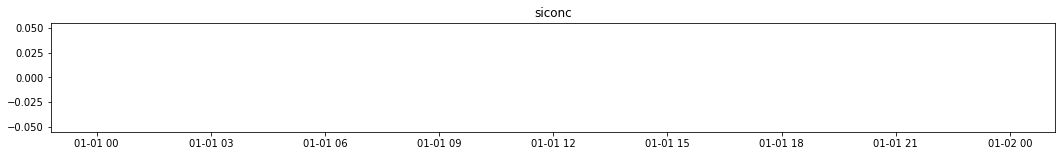

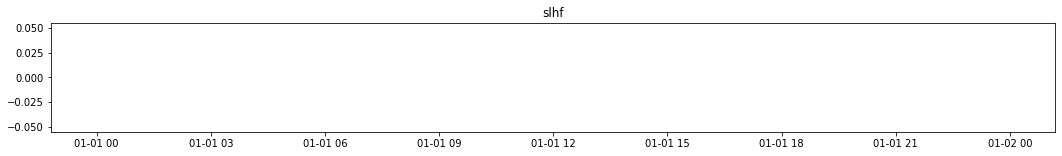

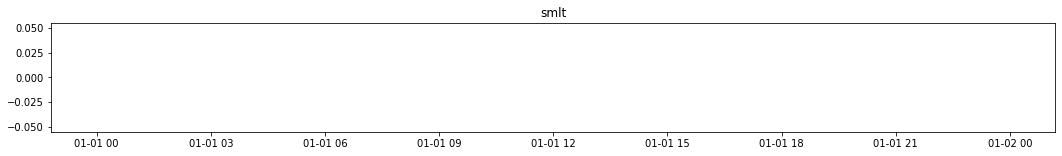

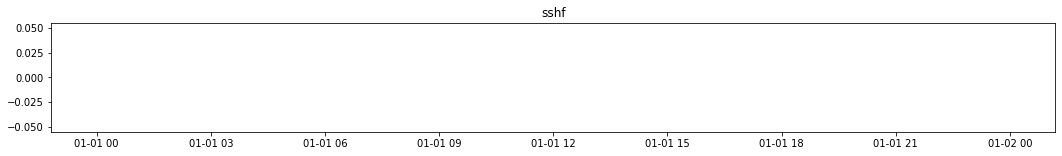

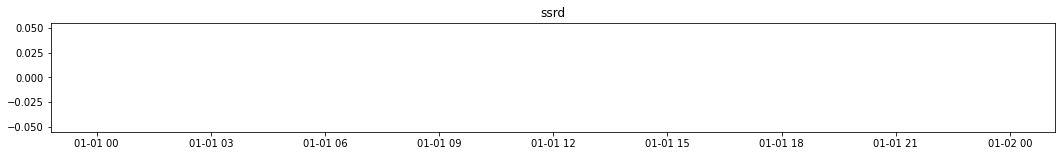

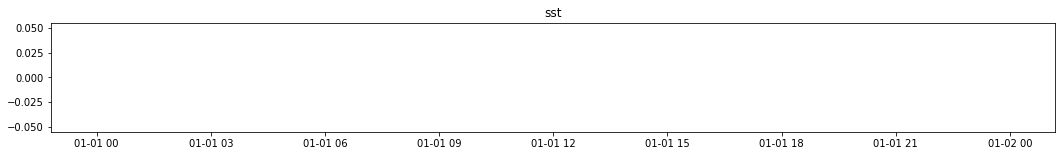

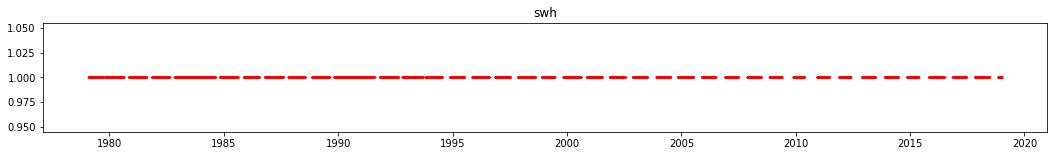

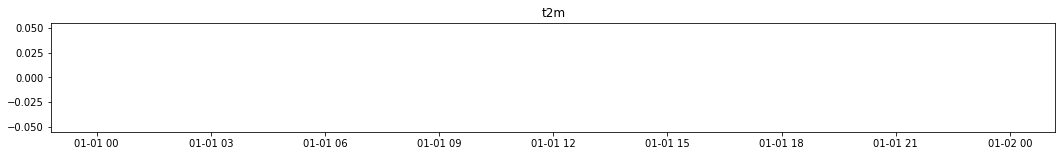

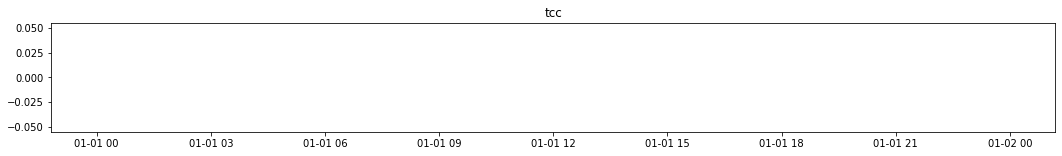

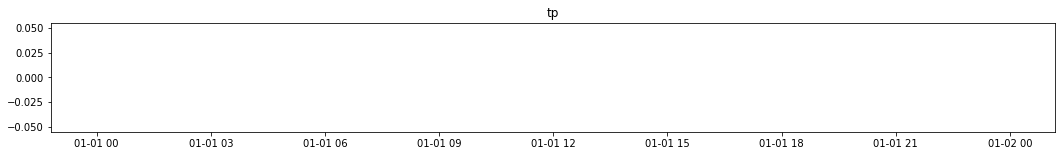

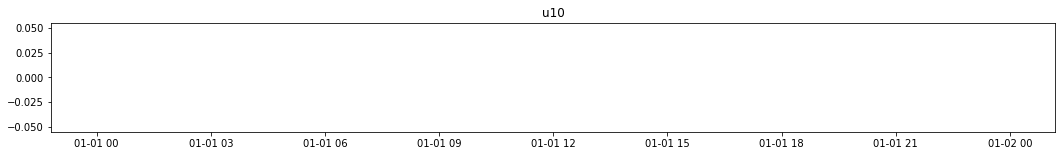

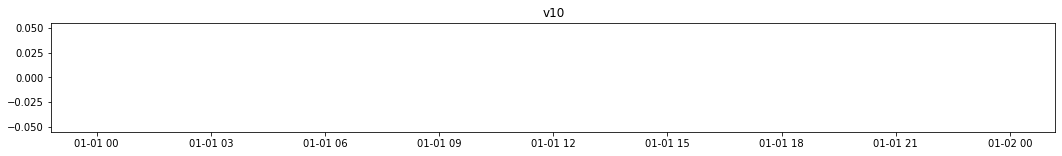

In [42]:
for d in ds.data_vars:
    plt.figure(figsize=(18, 2))
    plt.scatter(ds.time, np.where(np.isnan(ds.isel(latitude=50, longitude=50)[d]), 1, np.nan), c='r', s=1)
    plt.title(d)
    plt.show()